In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,BatchNormalization,Dropout
from tensorflow import keras
import os
# Working with directory library
from os import path, listdir
from os.path import isdir

# Image visualization
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
os.chdir("C:/Users/91934/OneDrive/Desktop/Capstone-V-Leaukemia Detection")

In [2]:
os.chdir("C:/Users/91934/OneDrive/Desktop/Capstone-V-Leaukemia Detection")

In [10]:

def load_image_dataset(file_path):
    all_image_dirs = [path.join(file_path, f) for f in listdir(file_path) if not isdir(path.join(file_path, f))]
    all_image_labels = []
    for f in all_image_dirs:
        if f.split('-')[1] == 'Benign':
            all_image_labels.append(1)
        elif f.split("-")[1]=="Malignant":
            temp=f.split("-")[2]
            if temp=="Early":
                all_image_labels.append(2)
            elif temp=="Pre":
                all_image_labels.append(3)
            elif temp=="Pro":
                all_image_labels.append(4)
    return all_image_dirs, all_image_labels
train_image_dirs, train_image_labels = load_image_dataset('train/images')
test_image_dirs, test_image_labels = load_image_dataset('test/images')
print(train_image_labels)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [4]:
# Put the image's paths and labels of train and test set to tensorflow dataset.

train_path_label = tf.data.Dataset.from_tensor_slices((train_image_dirs, train_image_labels))
test_path_label = tf.data.Dataset.from_tensor_slices((test_image_dirs, test_image_labels))

In [5]:


def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [196, 256])
    print(image)
    image /= 255.0  # normalize to [0,1] range
    image = 2*image-1  # normalize to [-1,1] range
    return image

def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)

def load_and_preprocess_from_path_label(path, label):
    return load_and_preprocess_image(path), label

In [6]:
# Load and preprocess all the images, put it in the same place with their labels.

train_image_label_ds = train_path_label.map(load_and_preprocess_from_path_label)
test_image_label_ds = test_path_label.map(load_and_preprocess_from_path_label).batch(1)

Tensor("resize/Squeeze:0", shape=(196, 256, 3), dtype=float32)
Tensor("resize/Squeeze:0", shape=(196, 256, 3), dtype=float32)


In [11]:
# implement batch for train set.

BATCH_SIZE = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_image_label_ds.shuffle(buffer_size = len(train_image_labels))
train_ds = train_ds.repeat()
train_ds = train_ds.batch(BATCH_SIZE)
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)


In [12]:
# Create an instance of MobileNetV2 as pre-trained model.

mobile_net = tf.keras.applications.MobileNetV2(input_shape=(196, 256, 3), include_top=False)
mobile_net.trainable=False

In [13]:
# Build the CNN-model

cnn_model = keras.models.Sequential([
    mobile_net,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dense(5, activation="softmax")
])

In [14]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 8, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 64)                81984     
                                                                 
 dense_1 (Dense)             (None, 5)                 325       
                                                                 
Total params: 2340293 (8.93 MB)
Trainable params: 82309 

In [15]:
# # Compile CNN-model

cnn_model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=["accuracy"])

In [17]:
# # Training the model with the train_ds above.

steps_per_epoch=tf.math.ceil(len(train_image_dirs)/BATCH_SIZE).numpy()
history=cnn_model.fit(train_ds, epochs=2, steps_per_epoch=steps_per_epoch, validation_data=test_image_label_ds)

Epoch 1/2


206/206 [==============================] - 165s 586ms/step - loss: 0.2641 - accuracy: 0.9152 - val_loss: 0.0956 - val_accuracy: 0.9646
Epoch 2/2
206/206 [==============================] - 108s 525ms/step - loss: 0.0889 - accuracy: 0.9716 - val_loss: 0.0735 - val_accuracy: 0.9743


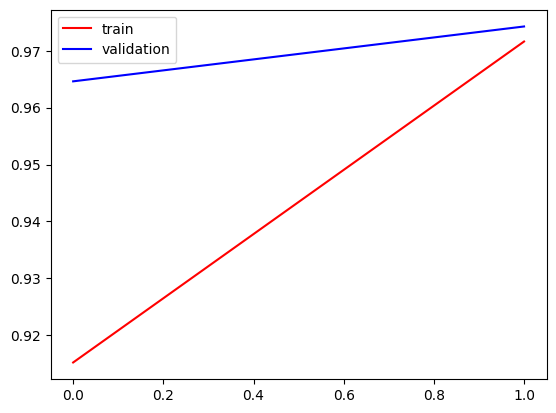

In [18]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

In [19]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [23]:

os.chdir("C:/Users/91934/OneDrive/Desktop/Capstone-V-Leaukemia Detection/test/images")

In [24]:
import numpy as np
from PIL import Image

def preprocess_input_image(image_path):
    img = Image.open(image_path)
    img = img.resize((256, 196))  # Resize image to match expected input shape
    img_array = np.array(img)
    img_array = img_array / 255.0  # Normalize pixel values
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

# Example usage
input_image_path = 'WBC-Malignant-Pro-362_jpg.rf.c9fe0d62649586c5b082affd40f15ad3.jpg'
input_image = preprocess_input_image(input_image_path)


In [25]:
prob = cnn_model.predict(input_image)
l = "None"

# Map label values to corresponding labels
label_mapping = {
    1: "benign",
    2: "Malignant-Early",
    3: "Malignant-Pre",
    4: "Malignant-Pro"
}

predicted_label_value = np.argmax(prob[0]) # Get the predicted label value (1-indexed)
if predicted_label_value in label_mapping:
    l = label_mapping[predicted_label_value]

print("Predicted label:", l)


1/1 [==============================] - 3s 3s/step
Predicted label: Malignant-Pro


In [26]:
print(l)

Malignant-Pro


In [127]:
cnn_model.save('lc.h5')

In [128]:
model_json = cnn_model.to_json()
with open("lc.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")

In [ ]:
conv_base = ResNet50(weights='imagenet', 
                  include_top=False,
                  input_shape=(img_width, img_height, 3))

# Show architecture
conv_base.summary()